# ДЗ №5 Сегментация
Реализация сети для сегметации объектов.

__Задача__ сделать работоспособную сеть для сегментирования изображений авто на основе предложенного шаблона


![Segmentation](../img/Segment04.png)

### Что делаем
Реализуем сверточную сеть для семантической сегментации, downsample->upsample -> Классификация каждого пикселя выходного изображения: 0 - не авто, 1 - авто. Выход картинка с x каналами, для классификации.
1. В файле model.py   - имплементировать модель вместо заглушки
2. В файле train.py - поставить правильный loss

### Данные
[Carvana](https://cloud.mail.ru/public/3tdq/AvtaHkDAb)

### Зависимости
 - tensorflow  - поддержка tensorboard
 - tensorboardx - тензор боард для pytorch
 - tqdm         - пакет для отрисовки прогресс баров

### Запуск пакета
_ По умолчанию все данные лежат в папке ./data/. Если вы положили их в другую папку, то поправте в скрипте train.py пути _
<br/>
Запускаем обучение сети
python train.py

Результаты обучение можно наблюдать в tensorboard

Запуск tensorboard --log ./od_log

## Результаты
1. Код model.py, train.py
2. Модель state_dicts()

### Тут нужно сделать загрузку состояния вашей модели, код модели в ноутбук тащить не нужно, достаточно сделать import model


In [0]:
# TODO
# import model ....
# Загружаем модель

In [2]:
import torch.nn.functional as F
from torch import nn
import torch
from torch.autograd import Variable
from torchvision.transforms import ToPILImage
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from tqdm import *

print(torch.__version__)
print(torch.cuda.is_available())

print(torch.cuda.device_count(), torch.cuda.get_device_name(0))

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print("CudaVersion : ",torch.version.cuda)

torch.cuda.empty_cache()

1.0.1.post2
True
1 Tesla T4
0
CudaVersion :  10.0.130


In [3]:
# Подключаем файлы с гугл-диска, так как работа сделана в колабе.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Почему-то при реконнекте коллаба это нужно указывать каждый раз.

!pip install tensorboardX

In [0]:
# Импортим модельку.

import sys
sys.path.append('gdrive/My Drive/New_hw_5_NN_test/')
from model_3 import UNet

net = UNet(3, 1)

# Загружаем состояние модели.

net.load_state_dict(torch.load('/content/gdrive/My Drive/damn_segm_model_3'))

In [0]:
# Импортим функцию для тренировки. Да, именно функцию, так как куда удобнее
# менять параметры запуска просто перезапуская cell, а не меняя исходный код.

import sys
sys.path.append('gdrive/My Drive/New_hw_5_NN_test/')
from train_3 import train_net

In [0]:
# Если нужно, тренеруем сетку.

# train_net(net, my_net_lr= 0.00008, useCuda=True, n_epoch=35,
#           batch_sz=10, load_state_dic=True)

In [8]:
## Реализуем тест модели на тестовом сете
## for ....
## замеряем среднюю метрику по тестовому сету, пример кода есть в train.py

import sys

sys.path.append('gdrive/My Drive/New_hw_5_NN_test/')
import carvana_dataset as cv

PATH = 'gdrive/My Drive/Technotrack_hw_5/data'
test = PATH + '/test/'
test_masks = PATH + '/test_masks'

useCuda = True
criterion = torch.nn.BCEWithLogitsLoss()

dl_test = cv.CarvanaDataset(test, test_masks)

net.train(False)
test_loss = 0

if useCuda == True:
    net = net.cuda()
    criterion = criterion.cuda()

for iter, (i, t) in enumerate(tqdm(dl_test)):
    i = i.unsqueeze(0)
    t = t.unsqueeze(0)
    with torch.no_grad():
        i = Variable(i)
        t = Variable(t)
    if useCuda:
        i = i.cuda()
        t = t.cuda()
    o = net(i)
    loss = criterion(o, t)
    test_loss += loss.item()
    
test_loss = test_loss / float(len(dl_test))
print("Test loss", test_loss)

100%|██████████| 508/508 [00:48<00:00, 11.00it/s]

Test loss 0.6124447980734307


### Тут нужно нарисовать картинки, с результатими сегментации из тестового сета

In [0]:
# TODO
# Для рандомного изображения рисуем его маску сгенерированную сеткой, само изображение и результат сегментации

In [0]:
import random
random.seed()

In [0]:
import sys
sys.path.append('gdrive/My Drive/New_hw_5_NN_test/')
import carvana_dataset as cv

PATH = 'gdrive/My Drive/Technotrack_hw_5/data'
log = './log/'
train = PATH + '/train/'
train_masks = PATH + '/train_masks/'
test = PATH + '/test/'
test_masks = PATH + '/test_masks'


ds = cv.CarvanaDataset(train, train_masks) 
ds_test = cv.CarvanaDataset(test, test_masks)

In [0]:
index = random.randint(0, len(ds_test))

In [0]:
test_image, test_mask = ds_test[index]

useCuda = True

if useCuda == True:
    test_image = test_image.cuda()
    test_mask = test_mask.cuda()

test_mask = test_mask.squeeze(0)

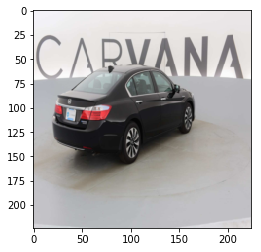

In [14]:
from torchvision.transforms import ToPILImage
to_PIL_img = ToPILImage()

plt.imshow(to_PIL_img(test_image.detach().cpu()))

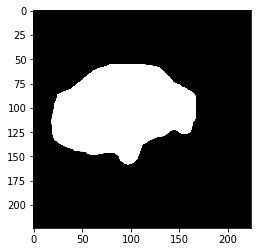

In [15]:
# Изображение, полученное сеткой.

net_image = net(test_image.unsqueeze(0)).chunk(2, dim=1)[0].squeeze(0).squeeze(0).cpu()
plt.imshow(net_image.detach().numpy(), cmap='gray')

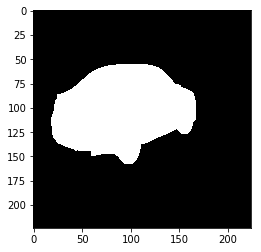

In [16]:
# Реальное изображение.

plt.imshow(test_mask.detach().cpu().numpy(), cmap='gray')